**Objective**: Build an XGBoost model for predicting heart disease and experiment with hyperparameter tuning to improve its performance.

Dataset: [Heart Disease UCI](https://archive.ics.uci.edu/dataset/45/heart+disease)

# Task 1: Data Loading and Exploration
1. Load the Heart Disease UCI dataset.
2. Explore the dataset to understand its structure and features.
3. Split the data into training and testing sets.

In [2]:
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
heart_disease = fetch_ucirepo(id=45) 
  
# data (as pandas dataframes) 
X = heart_disease.data.features 
y = heart_disease.data.targets 

# metadata 
print(heart_disease.metadata) 
  
# variable information 
print(heart_disease.variables)

{'uci_id': 45, 'name': 'Heart Disease', 'repository_url': 'https://archive.ics.uci.edu/dataset/45/heart+disease', 'data_url': 'https://archive.ics.uci.edu/static/public/45/data.csv', 'abstract': '4 databases: Cleveland, Hungary, Switzerland, and the VA Long Beach', 'area': 'Health and Medicine', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 303, 'num_features': 13, 'feature_types': ['Categorical', 'Integer', 'Real'], 'demographics': ['Age', 'Sex'], 'target_col': ['num'], 'index_col': None, 'has_missing_values': 'yes', 'missing_values_symbol': 'NaN', 'year_of_dataset_creation': 1989, 'last_updated': 'Fri Nov 03 2023', 'dataset_doi': '10.24432/C52P4X', 'creators': ['Andras Janosi', 'William Steinbrunn', 'Matthias Pfisterer', 'Robert Detrano'], 'intro_paper': {'title': 'International application of a new probability algorithm for the diagnosis of coronary artery disease.', 'authors': 'R. Detrano, A. Jánosi, W. Steinbrunn, M. Pfisterer, J. Schmid, S. Sa

In [3]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=42)

In [4]:
X_train.shape

(242, 13)

In [5]:
X_test.shape

(61, 13)

# Task 2: Data Preprocessing
1. Handle missing values if any.
2. Encode categorical variables using appropriate methods.
3. Standardize or normalize numerical features if necessary.

In [6]:
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [7]:
heart_disease = pd.concat([X,y], join='outer', axis=1)
heart_disease.isnull().sum()

numerical_features = heart_disease.select_dtypes(include=['float64']).columns
categorical_features = ['sex','cp','fbs','restecg','exang','slope','ca','thal']
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(), categorical_features)
    ]
)

# Task 3: Initial XGBoost Model
1. Build an initial XGBoost model using default hyperparameters.
2. Train the model on the training set and evaluate its performance on the testing set.
3. Note down the accuracy and any other relevant metrics.

In [8]:
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score

# Create an XGBoost model with parameters
params = {
    'learning_rate': 0.5,
    'n_estimators': 100,
    'max_depth': 5
}
xgb_model = XGBClassifier(**params)

# Encode the target variable using Label Encoding
label_encoder_xgb = LabelEncoder()
y_train_encoded = label_encoder_xgb.fit_transform(y_train)
y_test_encoded = label_encoder_xgb.transform(y_test)
# Train the model
xgb_model.fit(X_train, y_train_encoded.ravel())

# Make predictions on the test set
predictions_encoded = xgb_model.predict(X_test)

# Decode the predictions back to original labels if needed
predictions_original_labels = label_encoder_xgb.inverse_transform(predictions_encoded)

# Evaluate the accuracy of the model
accuracy = accuracy_score(y_test, predictions_original_labels)
print(f'Test accuracy: {accuracy}')


Test accuracy: 0.47540983606557374


C:\Users\marta\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\marta\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


# Task 4: Hyperparameter Tuning
1. Experiment with hyperparameter tuning to improve model performance.
2. Adjust hyperparameters such as learning_rate, n_estimators, max_depth, etc.
3. Use techniques like cross-validation to find optimal hyperparameters.
4. Train and evaluate the model with the tuned hyperparameters.

In [9]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier

In [10]:
param_grid = {
    'learning_rate': [0.1,0.3,0.5],
    'n_estimators': [100,200,300],
    'max_depth': [3,7,11]
}

xgb_classifier = XGBClassifier(objective='binary:logistic', eval_metric='logloss')

grid_search = GridSearchCV(estimator=xgb_classifier, param_grid=param_grid, cv=3, scoring='accuracy')
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
print("Best Parameters:", best_params)

best_xgb_classifier = XGBClassifier(**best_params)
best_xgb_classifier.fit(X_train, y_train)

# Evaluate on test set
accuracy = best_xgb_classifier.score(X_test, y_test)
print("Accuracy on Test Set:", accuracy)


Best Parameters: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 100}
Accuracy on Test Set: 0.5081967213114754


# Task 5: Feature Importance
1. Explore feature importance using the **feature_importances_** attribute of the trained XGBoost model.
2. Identify the most important features for heart disease prediction.

In [11]:
# Access feature importance scores
importance_scores = best_xgb_classifier.feature_importances_

# Create a dictionary mapping feature names to their importance scores
feature_importance_dict = dict(zip(X_train.columns, importance_scores))

# Sort the dictionary by importance scores in descending order
sorted_feature_importance = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)

# Print the sorted feature importance scores
for feature, importance in sorted_feature_importance:
    print(f"Feature: {feature}, Importance: {importance}")


Feature: cp, Importance: 0.1398404985666275
Feature: ca, Importance: 0.1285875141620636
Feature: thal, Importance: 0.12074780464172363
Feature: exang, Importance: 0.08827200531959534
Feature: oldpeak, Importance: 0.07935238629579544
Feature: fbs, Importance: 0.06970468163490295
Feature: thalach, Importance: 0.06273330003023148
Feature: slope, Importance: 0.05617593228816986
Feature: sex, Importance: 0.05611080676317215
Feature: age, Importance: 0.05470280349254608
Feature: chol, Importance: 0.053685516119003296
Feature: restecg, Importance: 0.046365879476070404
Feature: trestbps, Importance: 0.04372088983654976


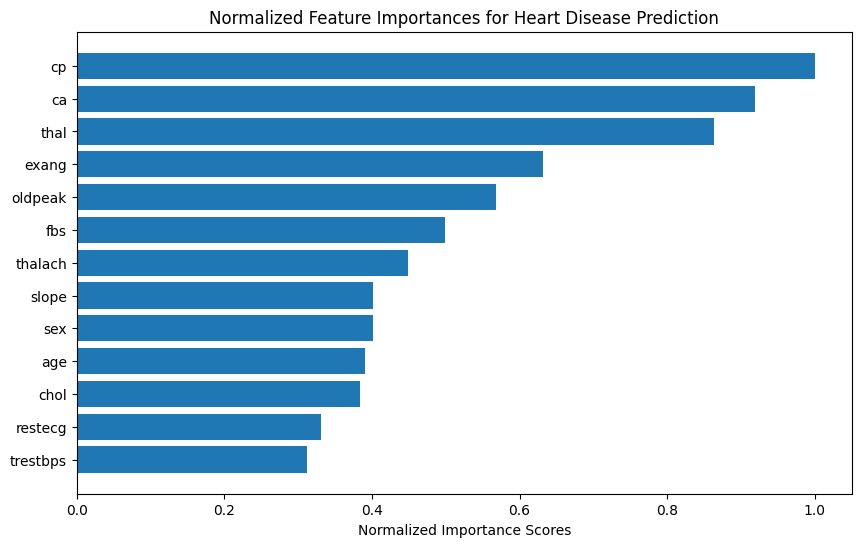

In [12]:
import matplotlib.pyplot as plt

# Extract feature names and importance scores from the sorted list
features, importance = zip(*sorted_feature_importance)

# Normalize importance scores
max_importance = max(importance)
normalized_importance = [score / max_importance for score in importance]

# Plotting the feature importances
plt.figure(figsize=(10, 6))
plt.barh(range(len(features)), normalized_importance, align='center')
plt.yticks(range(len(features)), features)
plt.xlabel('Normalized Importance Scores')
plt.title('Normalized Feature Importances for Heart Disease Prediction')
plt.gca().invert_yaxis()  # Invert y-axis to display most important at the top
plt.show()


# Task 6: Model Evaluation
1. Compare the performance metrics of the initial model and the tuned model.
2. Visualize the improvement achieved in a clear and concise manner.
3. Discuss the impact of hyperparameter tuning and feature importance on model performance.

In [13]:
from sklearn.metrics import precision_score, recall_score, f1_score

xgb_model.fit(X_train, y_train)
initial_predictions = xgb_model.predict(X_test)

# Calculate initial model performance metrics
initial_accuracy = accuracy_score(y_test, initial_predictions)
initial_precision = precision_score(y_test, initial_predictions, average='weighted')
initial_recall = recall_score(y_test, initial_predictions, average='weighted')
initial_f1 = f1_score(y_test, initial_predictions, average='weighted')

# Display initial model performance metrics
print("Initial Model Metrics:")
print(f"Accuracy: {initial_accuracy}")
print(f"Precision: {initial_precision}")
print(f"Recall: {initial_recall}")
print(f"F1 Score: {initial_f1}")


Initial Model Metrics:
Accuracy: 0.47540983606557374
Precision: 0.3971051262034869
Recall: 0.47540983606557374
F1 Score: 0.4323167791706847


In [14]:
best_xgb_classifier.fit(X_train, y_train)
tuned_predictions = best_xgb_classifier.predict(X_test)

# Calculate tuned model performance metrics
tuned_accuracy = accuracy_score(y_test, tuned_predictions)
tuned_precision = precision_score(y_test, tuned_predictions, average='weighted')
tuned_recall = recall_score(y_test, tuned_predictions, average='weighted')
tuned_f1 = f1_score(y_test, tuned_predictions, average='weighted')

# Display tuned model performance metrics
print("\nTuned Model Metrics:")
print(f"Accuracy: {tuned_accuracy}")
print(f"Precision: {tuned_precision}")
print(f"Recall: {tuned_recall}")
print(f"F1 Score: {tuned_f1}")



Tuned Model Metrics:
Accuracy: 0.5081967213114754
Precision: 0.4290398126463701
Recall: 0.5081967213114754
F1 Score: 0.46497519413287325


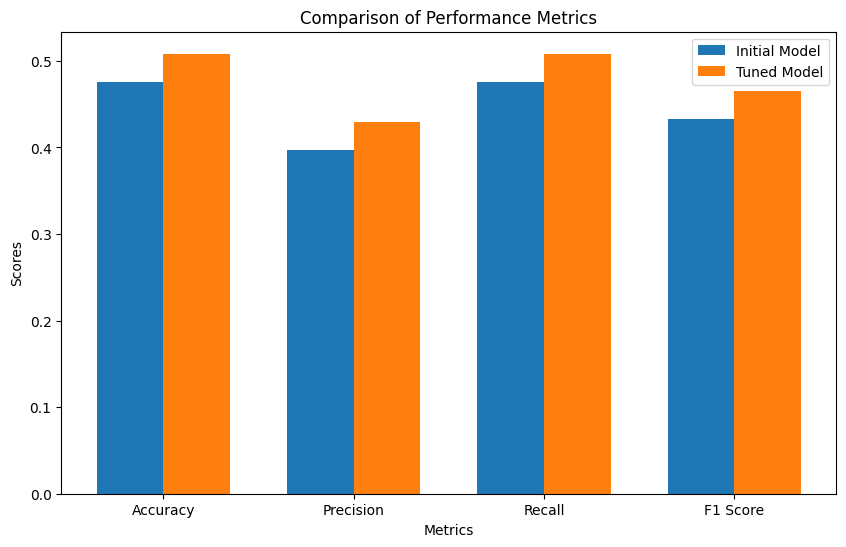

In [15]:
import matplotlib.pyplot as plt

# Metrics for comparison
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
initial_metrics = [initial_accuracy, initial_precision, initial_recall, initial_f1]
tuned_metrics = [tuned_accuracy, tuned_precision, tuned_recall, tuned_f1]

# Plotting the comparison
plt.figure(figsize=(10, 6))
bar_width = 0.35
index = range(len(metrics))
plt.bar(index, initial_metrics, bar_width, label='Initial Model')
plt.bar([i + bar_width for i in index], tuned_metrics, bar_width, label='Tuned Model')
plt.xlabel('Metrics')
plt.ylabel('Scores')
plt.title('Comparison of Performance Metrics')
plt.xticks([i + bar_width / 2 for i in index], metrics)
plt.legend()
plt.show()
